In [ ]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

## Decision making with ML in accounting

Machine learning models excel at making predictions. However, when we use machine learning in decision making, very often interpretability is as important as good predictions. Therefore, research on interpretable machine learning has increased substantially in the last few years, and new methods for the interpretation is introduced almost weekly. To introduce everything would be impossible and therefore, I try to focus on the following to most popular methods that have established their place in the decision making process. Hopefully, this gives a reader knowledge in fundamentals of interpretable machine learning,

One could ask why we need interpretations? If our model state-of-the-art in prediction, why not just trust the model and forget what is the reason for such a prediction? First of all, even prediction performance can not be measured with a single metric. In the figure below, you see the collection of metrics that we can use to measure binary-classification performance. So, even the prediction performance of a model depends on the metric (interpretation) used.

![conf_matrix](./images/conf_matrix.png)

But even if we could measure prediction performance reliably, the interpretation of a model is essential in many applications. Even if we could predict customer churn in our company accurately, we would probably like to know **why** they will churn. Or, if we are using an ML model in our bank to decide who gets a loan an who doesn't, we are probably obliged to **explain** why our model, for example, rejected a loan application. Furthermore, in some applications understanding the behaviour of a machine learning model can help us learn more about the problem, the data and the reason why a model might fail. Of course, this is not the case always. For example, it is not vital for a company to understand how its' product recommendation system works. It is enough that it works well and gives the customers recommendation that boosts sales. Furthermore, some methods are extensively studied and evaluated, and therefore, do not need extensive interpretation.

However, interpretation of machine learning models is vital in many applications and the subject of increasing research interest in the ML research community. The more ML is affecting our lives, the more important it is for us to understand its' behaviour. As an example of good progress in the field, internet companies nowadays add an explanation to their product recommendations in the form of products often bought together -list.

![why](./images/why.png)

In the following, I will go through the most common ML explanation methods. I will explain only the basic idea behind the method and avoid any math. In section 3.2, we will analyse some of these methods in more detail.

### Plots

#### Partial dependence plot
The partial dependence plot (PDP) is a  tool to analyse the marginal effect of one (or few) variables on the prediction. It is calculated by averaging out the effect of other variables. It shows us the functional form of the relationship between the target and a variable. So, initially, the PDP appears to be an excellent tool to analyse the effect of variables to the prediction. However, the assumption of independence is the main issue with PDP plots. The method assumes that the features of a model are not correlated. Because of this, the method also ignores interactions (between analysed and non-analysed variables).

![pdp](./images/Partial_depenence_plots.png)

#### Individual conditional expectations
Individual Conditional Expectation (ICE) plots basically display a PDP line for every instance. Thus, ICE plots show how a variable affects the prediction for every instance separately. A PDP is the average of the lines of an ICE plot. This solves the problem of interaction that PDP plots have. However, the independence assumption still holds and is also on an issue with ICE plots.

![ice_plot](./images/ICE.png)

#### Accumulated local effects
Accumulated local effects plots are similar to PDP and ICE plots, i.e., they show how a feature affects the prediction on average. However, the main benefit of ALE plots is that they do not suffer about problems caused by the independence assumption.  So, they are an unbiased alternative to PDP plots.

![ale_plot](./images/ale.png)

### Local and global explanations

#### Permutation feature importance
The permutation feature importance is defined to be the increase in the prediction error when a single feature value is randomly shuffled, thus, breaking the relationship between the feature and the target. The increase of the prediction error is indicative of how much the model depends on the feature.

#### Global surrogate models
The idea of global surrogate models is very simple. We build an interpretable model that is trained to approximate a non-interpretable machine learning model. Then we analyse the ML model by examining this interpretable surrogate model. Basically, we are interpreting machine learning with machine learning.

#### Local surrogate models
Local surrogate models are very similar to global surrogate models. However, instead of a global surrogate, local surrogate models try to explain individual predictions. Currently, as far as the author knows, there is only one implementation of local surrogate models to Python, called Local Interpretable Model-agnostic Explanations (LIME).

#### Shapley additive explanations
SHapley Additive exPlanations (SHAP) is a method to explain individual predictions using the game-theoretically optimal Shapley Values. The methods give an estimate for every instance, how the model's prediction depends on each feature. Basically, the prediction is split into parts, where each part represents the effect of one feature to the prediction. This allows us to draw, for example, scatter charts that can be used to infer the functional form of the dependence between a feature and the target. Furthermore, because SHAP is based on Shapley values, it also accounts complex interactions between the features.

![shap_sc](./images/shap_sc.png)

#### Shapley additive global explanations
Initially, the SHAP values were considered to be efficient methods for global explanations. However, because the SHAP values are contributions of each feature to the prediction, it is difficult to construct a reliable aggregate metric, for example, to feature importance. This is solved in Shapley Additive Global importancE (SAGE). Instead of estimating the contribution of features to the prediction, the SAGE values estimate the contribution of each feature to the decrease of the loss function. Therefore, for example, an average of individual explanations would be a reliable estimate of feature importance. Like SHAP, SAGE also accounts for complex feature interactions, because it is based on Shapley values.

![sage_plot](./images/sage.png)

### Decision making example - gradient boosting and a collection of interpretation metrics

In [41]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

In this example, we will train an Xgboost-model to company data that has a collection of financial figures. Then, we will use a set of interpretation metrics to analyse our results.

Let's start by loading our data. For that, we need the pandas library that has a convenient function to read csv-files.

In [2]:
import pandas as pd

**index_col=0** defines the location of an index column. This csv-file is not available anywhere. If you want to repeat the analysis, create a csv-file that has companies as rows and different financial figures as columns.

In [3]:
master_df = pd.read_csv('FINAL_FIGURES_PANEL.csv',index_col=0)

Our example data is not the best one. It has many missing values and even some inf-values. To make further analysis easier, I set pandas to consider inf-values as nan-values.

In [4]:
pd.options.mode.use_inf_as_na = True

We build a model where we try to predict Tobin's Q using other financial figures from companies. Therefore we should remove those instances that do not have a Tobin's Q value. With **loc** we can locate instances, in this case, those instances that have a missing value (**isna()** tells that) in the Tobin's Q variable.
Because we removed some instances, the index is now all messed up. With **reset_index()** we can set it back to a sequential row of numbers.

In [5]:
master_df = master_df.loc[~master_df['TobinQ'].isna()]
master_df.reset_index(inplace=True,drop=True)

Below, we apply winsorisation to the data. An explanation from Wikipedia: "Winsorisation is the transformation of statistics to set all outliers to a specified percentile of the data; for example, a 90% winsorisation would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile.

In [6]:
master_df['TobinQ'].clip(lower=master_df['TobinQ'].quantile(0.05), upper=master_df['TobinQ'].quantile(0.95),inplace = True)

With pandas, we can quickly draw a histogram of a variable. Here is Tobin's Q. The higher frequency of values around twelve is caused by winsorisation.

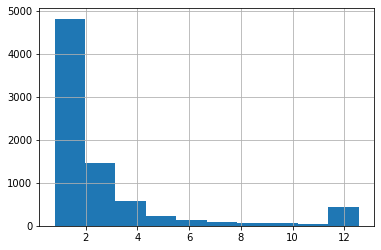

In [7]:
master_df['TobinQ'].hist()

Our dataframe has many variables. However, there are very similar variables, and we use only part of them to get meaningful results.

In [8]:
master_df.columns

Index(['CIK', 'Name', 'Year', 'TOTAL ASSETS (U.S.$)', 'COMMON EQUITY (U.S.$)',
       'MARKET CAPITALIZATION (U.S.$)', 'NET SALES OR REVENUES (U.S.$)',
       'NET INCOME (U.S.$)', 'EARNINGS PER SHARE',
       'EARNINGS BEF INTEREST & TAXES', 'DIVIDEND YIELD - CLOSE',
       'NET SALES/REVENUES -1YR ANN GR', 'NET INCOME - 1 YR ANNUAL GROWT',
       'RETURN ON EQUITY - TOTAL (%)', 'RETURN ON ASSETS',
       'RETURN ON INVESTED CAPITAL', 'SELLING, GENERAL & ADM / SALES',
       'RESEARCH & DEVELOPMENT/SALES', 'OPERATING PROFIT MARGIN',
       'TOTAL DEBT % TOTAL CAPITAL/STD', 'QUICK RATIO', 'CURRENT RATIO',
       'BRANDS, PATENTS - NET', 'BRANDS, PATENTS - ACCUM AMORT',
       'BRANDS, PATENTS - GROSS', 'EMPLOYEES',
       'EMPLOYEES - 1 YR ANNUAL GROWTH', 'SALES PER EMPLOYEE',
       'ASSETS PER EMPLOYEE', 'CURRENT LIABILITIES-TOTAL', 'TOTAL LIABILITIES',
       'TOTAL INVESTMENT RETURN', 'PRICE/BOOK VALUE RATIO - CLOSE',
       'PRICE VOLATILITY', 'FOREIGN ASSETS % TOTAL ASSETS',
    

As predictors, we pick the following variables. There are still highly correlated variables. One good aspect of tree-based boosting methods is that multicollinearity is much less of an issue.

In [9]:
features = ['Year', 'DIVIDEND YIELD - CLOSE',
       'NET SALES/REVENUES -1YR ANN GR', 'NET INCOME - 1 YR ANNUAL GROWT',
       'RETURN ON EQUITY - TOTAL (%)', 'RETURN ON ASSETS',
       'RETURN ON INVESTED CAPITAL', 'SELLING, GENERAL & ADM / SALES',
       'RESEARCH & DEVELOPMENT/SALES', 'OPERATING PROFIT MARGIN',
       'TOTAL DEBT % TOTAL CAPITAL/STD', 'QUICK RATIO', 'CURRENT RATIO',
       'TOTAL INVESTMENT RETURN',
       'PRICE VOLATILITY', 'FOREIGN ASSETS % TOTAL ASSETS',
       'FOREIGN SALES % TOTAL SALES', 'FOREIGN INCOME % TOTAL INCOME',
       'FOREIGN RETURN ON ASSETS', 'FOREIGN INCOME MARGIN',
       'ACCOUNTS PAYABLE/SALES', 'CASH FLOW/SALES', 'COST OF GOODS SOLD/SALES']

We temporarily move the predictor variables to another dataframe for winsorisation.

In [10]:
features_df = master_df[features]

In [11]:
features_df.clip(lower=features_df.quantile(0.05), upper=features_df.quantile(0.95), axis = 1,inplace = True)

We move back the winsorised predictor variables to master_df.

In [12]:
master_df[features] = features_df

With the pandas function **describe()**, we can easily calculate basic statistics for the features.

In [13]:
master_df[features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,7921.0,2005.090393,7.337131,1994.0000,1999.0000,2005.0000,2011.00000,2018.00000
DIVIDEND YIELD - CLOSE,7893.0,0.486829,0.910837,0.0000,0.0000,0.0000,0.58000,2.96000
NET SALES/REVENUES -1YR ANN GR,7579.0,11.159821,30.259285,-38.0540,-5.7000,6.4700,22.32500,91.86900
NET INCOME - 1 YR ANNUAL GROWT,3815.0,45.183943,112.854050,-75.5250,-18.8100,15.1100,62.18500,406.44900
RETURN ON EQUITY - TOTAL (%),6862.0,-4.885381,38.409156,-123.8240,-9.7600,7.0200,16.31750,37.71850
RETURN ON ASSETS,7687.0,-9.839917,37.518729,-140.5340,-9.0950,3.9300,8.73000,18.58700
RETURN ON INVESTED CAPITAL,7305.0,-6.064327,34.695127,-116.9260,-8.8900,5.8600,12.79000,27.58000
"SELLING, GENERAL & ADM / SALES",7640.0,36.152825,41.764955,8.5995,15.5675,22.2400,33.48500,185.97300
RESEARCH & DEVELOPMENT/SALES,6635.0,10.029486,11.853524,0.0000,1.9100,5.3800,13.65500,46.55100
OPERATING PROFIT MARGIN,7694.0,-14.559555,61.399007,-243.9660,-5.0300,5.6200,11.09750,21.11800


Tobin's Q to the **y_df** dataframe.

In [14]:
y_df = master_df['TobinQ']

The features to the **x_df** dataframe.

In [15]:
x_df = master_df[features]

#### Gradient boosting
**Xgboost** is implemented as a Python library, which we import here and name it **xgb**.

In [16]:
import xgboost as xgb

Xgboost uses its' own data structure, called DMatrix. It speeds up calculations significantly and saves memory. We feed the data as pandas dataframes. The data can also be numpy arrays. **nthread = -1** tells Xgboost to use all the cores available for calculations.

In [17]:
dtrain = xgb.DMatrix(x_df, label=y_df, nthread = -1)

Next, we need to define the parameters of the xgboost model. This is a very difficult task and more like black magic than science. You can easily play with different hyperparameter settings for days, and still finding combinations that improve performance. And here is only part of the parameters! More info about the parameters is here: [xgboost.readthedocs.io/en/latest/parameter.html](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [18]:
m_depth = 5
eta = 0.1
ssample = 0.8
col_tree = 0.8
m_child_w = 3
gam = 1.
objective = 'reg:squarederror'
param = {'max_depth': m_depth, 'eta': eta, 'subsample': ssample,
         'colsample_bytree': col_tree, 'min_child_weight' : m_child_w, 'gamma' : gam,'objective' : objective}

Xgboost has a function for cross-validation. We use here 5 folds. The metric is **mean absolute error**.
![validation](./images/Train-Test-Validation.png)

In [19]:
temp = xgb.cv(param,dtrain,num_boost_round=1500,nfold=5,seed=10,metrics='mae')

To plot how our *mae* is decreasing, we load Matplotlib.

In [20]:
import matplotlib.pyplot as plt

There are indications for overfitting, but let's proceed. Around 800 rounds (decision trees), the validation error is minimum, so let's use that.

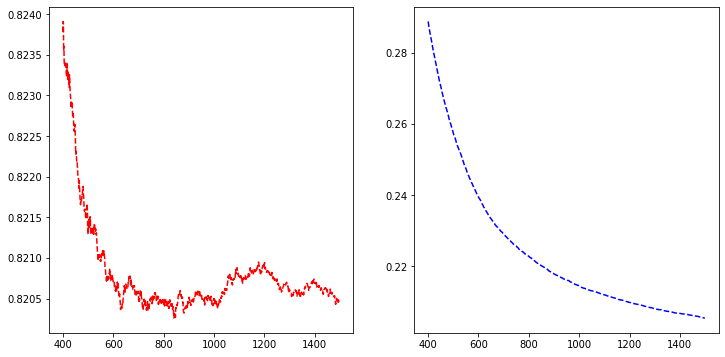

In [21]:
fig, axs = plt.subplots(1,2,figsize=(12,6),squeeze=True)
axs[0].plot(temp['test-mae-mean'][400:1500],'r--')
axs[1].plot(temp['train-mae-mean'][400:1500],'b--')

In [22]:
b_rounds = 800

**train()** is used for training. We feed the parameters, the data in a DMAtrix format and the number of boosting rounds to the function.

In [23]:
bst = xgb.train(param,dtrain,num_boost_round=b_rounds)

#### SHAP

Now we have our model trained, and we can start analysing it. Let's start with SHAP [github.com/slundberg/shap](https://github.com/slundberg/shap)

In [24]:
import shap

In [25]:
j=0
shap.initjs()

We define a SHAP tree-explainer and use the data to calculate the SHAP values.

In [26]:
explainerXGB = shap.TreeExplainer(bst)
shap_values_XGB_test = explainerXGB.shap_values(x_df,y_df)

SHAP has many convenient functions for model analysis.

Summary_plot with **plot_type = 'bar'** for a quick feature importance analysis. However, for global importance analysis, you should use SAGE instead, because SHAP is prone to errors with the least important features.

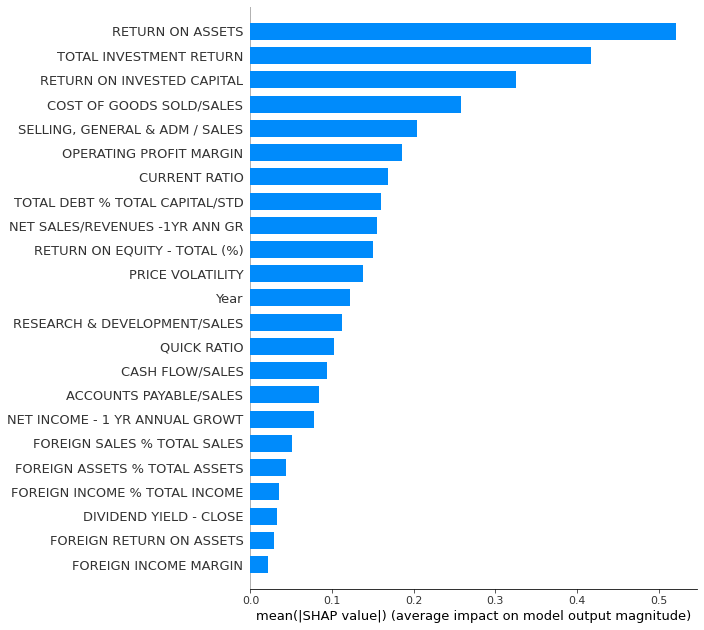

In [27]:
shap.summary_plot(shap_values_XGB_test,x_df,plot_type='bar',max_display=30)

With **plot_type = 'dot'** we get a much more detailed plot.

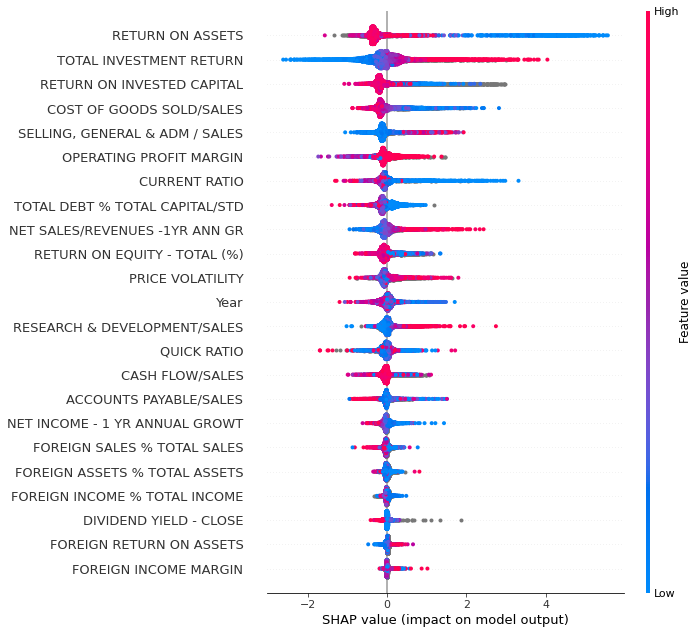

In [28]:
shap.summary_plot(shap_values_XGB_test,x_df,plot_type='dot',max_display=30)

Next, we use the SHAP values to build up 2D scatter graphs for every feature. It shows the effect of a feature for the prediction for every instance.

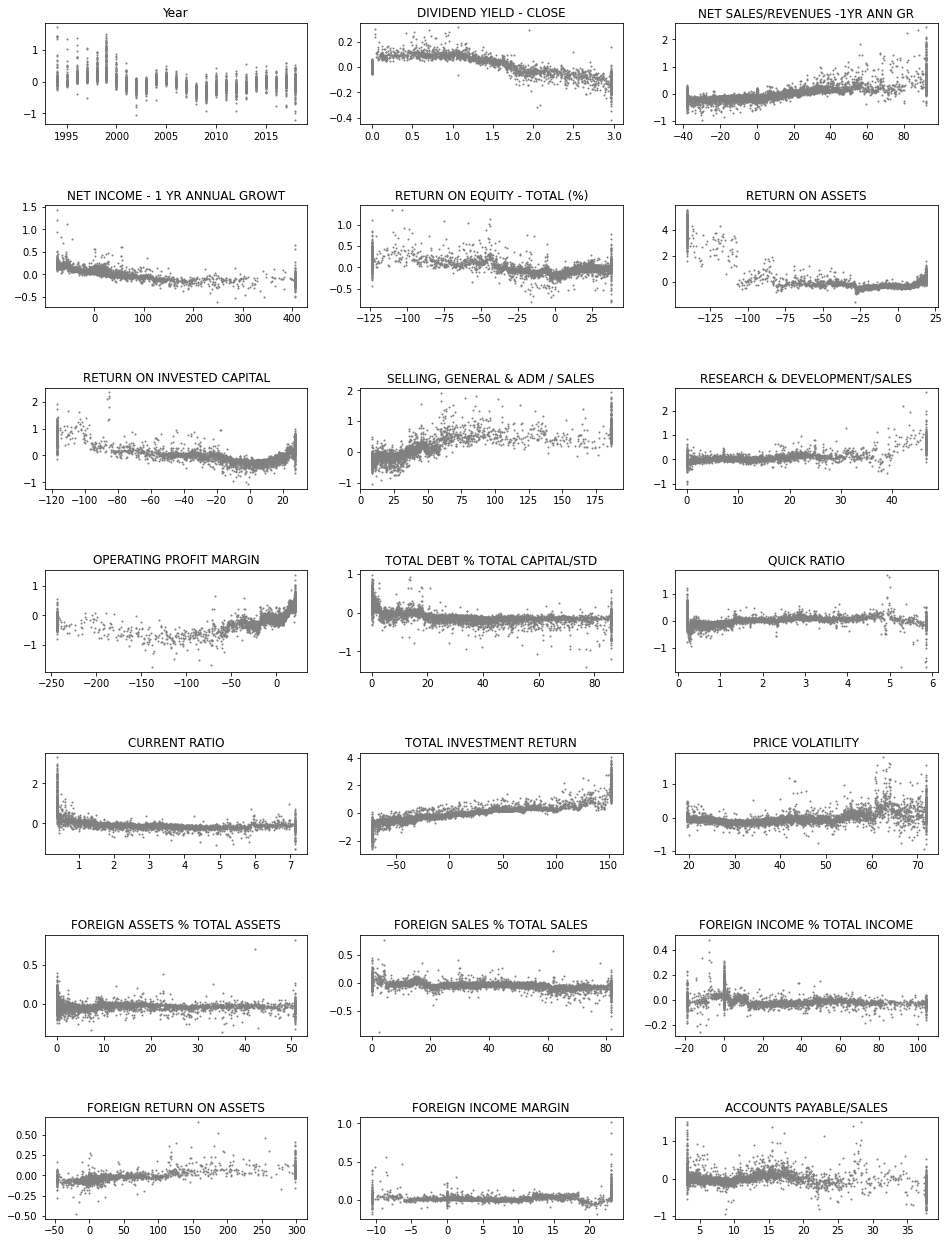

In [29]:
fig, axs = plt.subplots(7,3,figsize=(16,22),squeeze=True)
ind = 0
for ax in axs.flat:
    feat = bst.feature_names[ind]
    ax.scatter(x_df[feat],shap_values_XGB_test[:,ind],s=1,color='gray')
#    ax.set_ylim([-0.2,0.2])
    ax.set_title(feat)
    ind+=1
plt.subplots_adjust(hspace=0.8)
plt.savefig('shap_sc.png')

**Decision_plot()** is interesting as it shows how the prediction is formed from the contributions of different features.

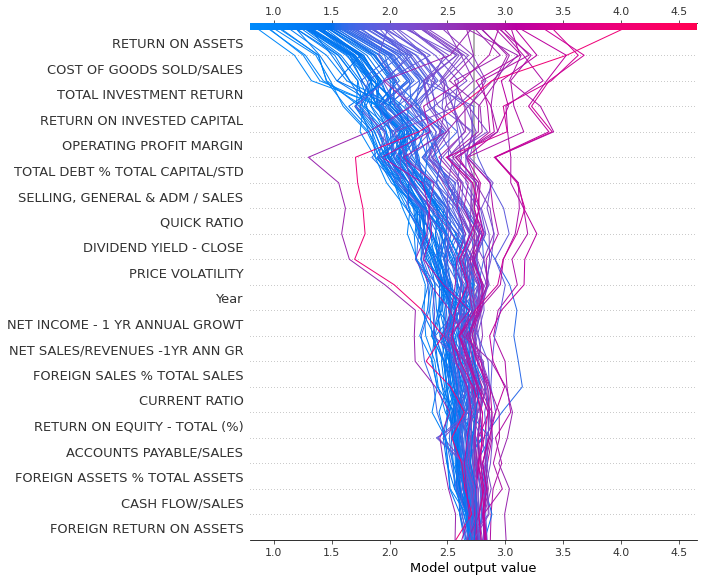

In [30]:
shap.decision_plot(explainerXGB.expected_value,shap_values_XGB_test[0:100],features)

**Force_plot** is similar to decision_plot. We plot only the first 100 instances because it would be very slow to draw a force_plot with all the instances.

In [31]:
shap.force_plot(explainerXGB.expected_value,shap_values_XGB_test[0:100],features,figsize=(20,10))

**Waterfall_plot** is great when you want to analyse one instance.

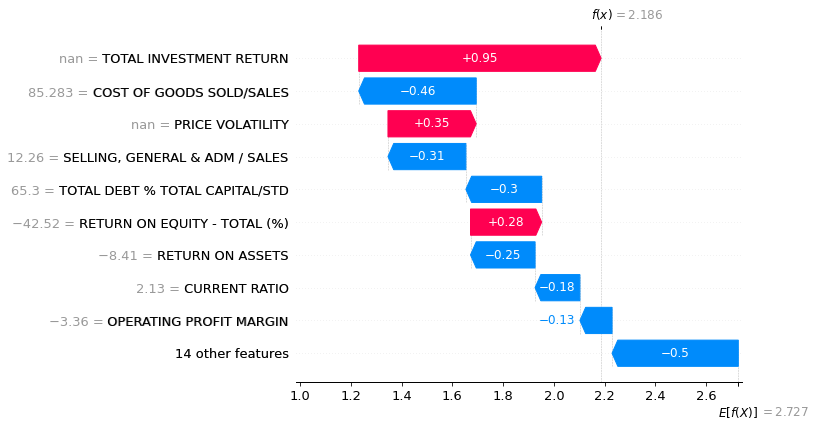

In [32]:
shap.waterfall_plot(explainerXGB.expected_value,shap_values_XGB_test[2000],x_df.iloc[2000],features)

#### Other interpretation methods

For the following methods, we need to use Xgboost's Scikit-learn wrapper **XGBRegressor()** to turn our Xgboost to be compatible with the Scikit-learn ecosystem.

In [33]:
m_depth = 5
eta = 0.1
ssample = 0.8
col_tree = 0.8
m_child_w = 3
gam = 1.
objective = 'reg:squarederror'
param = {'max_depth': m_depth, 'eta': eta, 'subsample': ssample,
         'colsample_bytree': col_tree, 'min_child_weight' : m_child_w, 'gamma' : gam,'objective' : objective}

Our xgboost model as a Scikit-learn model.

In [34]:
best_xgb_model = xgb.XGBRegressor(colsample_bytree=col_tree, gamma=gam,
                                  learning_rate=eta, max_depth=m_depth,
                                  min_child_weight=m_child_w, n_estimators=800, subsample=ssample)

**fit()** is used to train a model in Scikit.

In [35]:
best_xgb_model.fit(x_df,y_df)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1.0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

**pdpbox** library has a function for partial dependence plot and individual conditional expectations: [github.com/SauceCat/PDPbox](https://github.com/SauceCat/PDPbox)

In [36]:
from pdpbox import pdp

Here is a code to draw a partial dependence plot and individual conditional expectations. **features[5]** is the feature Return on Assets. These methods do not like missing values in features, so we fill missing values with zeroes. Not a theoretically valid approach, but...

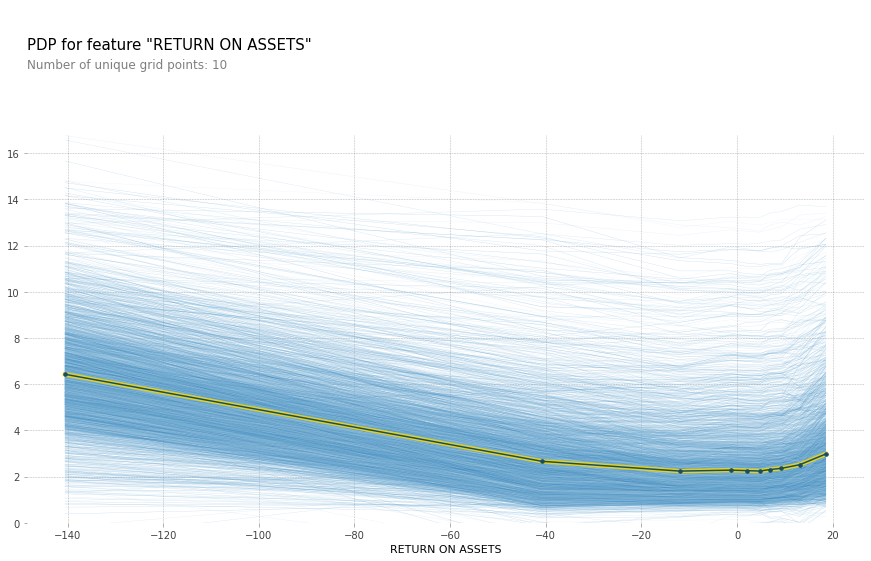

In [37]:
plt.rcParams["figure.figsize"] = (20,20)
pdp_prep = pdp.pdp_isolate(best_xgb_model,x_df.fillna(0),features,features[5])
fig, axes = pdp.pdp_plot(pdp_prep, features[5],center=False, plot_lines=True,frac_to_plot=0.5)
plt.savefig('ICE.png')

ALEPython has functions for ALE plots: [github.com/blent-ai/ALEPython](https://github.com/blent-ai/ALEPython)

In [38]:
import ale

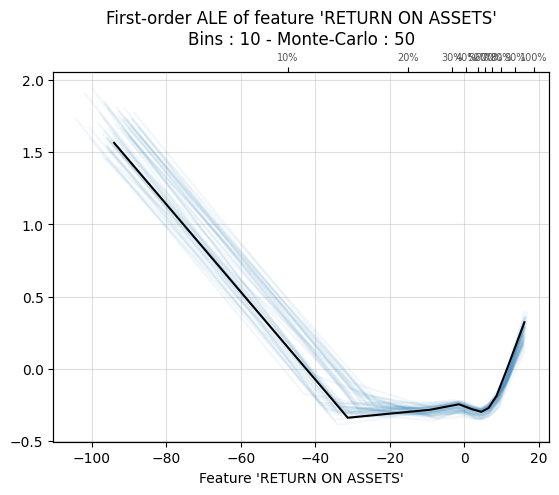

<Figure size 640x480 with 0 Axes>

In [40]:
plt.rcdefaults()
ale.ale_plot(best_xgb_model,x_df.fillna(0),features[5],monte_carlo=True)
plt.savefig('ale.png')